In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 679 kB 6.5 MB/s 


In [ ]:
import os, cv2, sys, time, datetime, glob
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, ReLU, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import Add, Lambda, ZeroPadding2D
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path definition based on the student:
persona = "m"   # 'l' Luca, 'm' Michela, 's' Sofia
if persona=="l":
    orig = "/content/drive/MyDrive/Sapienza Magistrale/Corsi Attuali/Vision and Perception/Progetto V&P Condiviso/Finale/"
elif persona=="m":
    orig = "/content/drive/MyDrive/VP/Project/"
elif persona=="s":
    orig = ""
else:
    sys.exit("Wrong User and it is impossible to define the directory. Try Again.")

# For Training:
name_image = "brain_MRI"
selected_image=orig+'Images/'+name_image+'.png'
date_training = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
save_path = orig+'Summaries/'+name_image+"_"+date_training

# For Testing:
output_testing_path = orig+"Testing/"+name_image+"-"+date_training

In [ ]:
# We read the image indicated by the path, we decode the png to a uint8, specifying
# we want as output a RGB image (3 channels) and then we cast it to a float32.
# Eventually, the image gets resized using the function above.
def load_image(path_to_img, img_size=None):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    if img_size:
        img = tf.image.resize(img, (img_size, img_size), method=tf.image.ResizeMethod.BILINEAR,
                                antialias=True, preserve_aspect_ratio=True)
    return tf.expand_dims(img, 0)  # we add a new axis in position 0

# Resizes the image using bilinear interpolation and the sampling filter will
# also anti-alias the image. In particular, while downsampling an image with
# anti-aliasing the sampling filter kernel is scaled to anti-alias the input
# image signal.
def resize_image(img, min_size=0, scale_factor=None, shape_new=None):
    if shape_new:               # we directly ask to resize the image to a specific height and width
        h_new = shape_new[1]
        w_new = shape_new[2]
    elif scale_factor:
        h_new = tf.maximum(min_size, tf.cast(img.shape[1]*scale_factor, tf.int32))  # get the new height by taking the max between the min size and the old height 
                                                                                    # multiplied by the scale factor
        w_new = tf.maximum(min_size, tf.cast(img.shape[2]*scale_factor, tf.int32))  # get the new width by taking the max between the min size and the old width 
                                                                                    # multiplied by the scale factor
    img = tf.image.resize(img, (h_new, w_new), method=tf.image.ResizeMethod.BILINEAR, antialias=True) # resize image to the new height and width using bilinear interpolation
    return img

# The input value is expected between -1 and 1
def save_image(img, path):
    # Inverts the previous normalization
    img = (img+1)*127.5
    # Returns the values of the image between 0 and 255
    img = tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=255.0)
    img = Image.fromarray(np.array(img).astype(np.uint8).squeeze())
    img.save(path)

# Normalizes the input image between [-1, 1]
def normalize(img):
    return img/127.5-1

In [ ]:
# It is a convolutional block that is called inside the generator and the discriminator
class ConvBlock(Layer):
    def __init__(self, n_filters):
        super(ConvBlock, self).__init__()
        self.n_filters = n_filters
        self.kernel_initializer = tf.random_normal_initializer(0., 0.02)
        self.conv = Conv2D(filters=self.n_filters, kernel_size=3,
                             strides=1, padding='valid', use_bias=False,
                             kernel_initializer=self.kernel_initializer)
        #self.batch_norm = BatchNormalization()
        self.instance_norm = tfa.layers.InstanceNormalization(axis=3, 
                                   center=True, 
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")

    def call(self, x):
        x = self.conv(x)
        #x = self.batch_norm(x)
        x = self.instance_norm(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

In [ ]:
# Generator -> it is trained to fool the discriminator, not making it able to distinguish the
# generated image from the original one
class Generator(Model):
    def __init__(self, n_filters, name='Generator'):
        super(Generator, self).__init__()
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.padding = ZeroPadding2D(5)
        self.conv1 = ConvBlock(n_filters)
        self.conv2 = ConvBlock(n_filters)
        self.conv3 = ConvBlock(n_filters)
        self.conv4 = ConvBlock(n_filters)
        self.conv5 = Conv2D(filters=3, kernel_size=3, strides=1, padding='valid',
                           activation='tanh', kernel_initializer=self.initializer)

    def call(self, image, noise):
        image_pad = self.padding(image)
        noise_pad = self.padding(noise)
        # Add: It takes as input a list of tensors (all of the same shape) and returns a single tensor (also of the same shape).
        x = Add()([image_pad, noise_pad])
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = Add()([x, image])

        return x

In [ ]:
# Discriminator -> needs to understand if the input image is fake or real
class Discriminator(Model):
    def __init__(self, n_filters, name='Discriminator'):
        super(Discriminator, self).__init__()
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.conv1 = ConvBlock(n_filters)
        self.conv2 = ConvBlock(n_filters)
        self.conv3 = ConvBlock(n_filters)
        self.conv4 = ConvBlock(n_filters)
        self.conv5 = Conv2D(filters=1, kernel_size=3, strides=1, padding='valid',
                           kernel_initializer=self.initializer)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

In [ ]:
def create_directory(dir):
    if not os.path.exists(dir):   # create a new directory if it does not already exist
        os.makedirs(dir)
        print(f'Directory {dir} created')
    else:
        print(f'Directory {dir} already exists')  
    return dir

In [ ]:
class Trainer:
    def __init__(self, n_scales, n_iters, max_size, min_size, scale_factor,learning_rate, checkpoint_dir, summary):
        self.n_scales = n_scales
        self.n_iters = n_iters  # number of iterations while training each single scale
        self.n_filters = [32*pow(2, (scale//4)) for scale in range(self.n_scales)] # n_filters double every 4 scales
        self.max_size = max_size    # max allowed size of the image
        self.min_size = min_size    # min allowed size of the image
        self.scale_factor = scale_factor
        self.noise_initial_amplitude = 0.1
        self.checkpoint_dir = checkpoint_dir
        self.gen_dir = self.checkpoint_dir + '/G'
        self.dis_dir = self.checkpoint_dir + '/D'
        self.lr_decay = ExponentialDecay(learning_rate, decay_steps=4800, decay_rate=0.1, staircase=True) # exponential decay of the learning rate
        self.create_model()   # creates a generator/discriminator pair for each scale
        self.summary = summary
        if self.summary:
            self.create_summary_writer()
            self.build_metrics()

    # It creates a generator/discriminator pair for each scale
    def create_model(self):
        create_directory(self.checkpoint_dir)
        self.generators = []
        self.discriminators = []
        for scale in range(self.n_scales):
            self.generators.append(Generator(n_filters=self.n_filters[scale]))
            self.discriminators.append(Discriminator(n_filters=self.n_filters[scale]))    

    # It saves the weights of the generators and discriminators and the current noise amplitude
    def save_model(self, scale):
        gen_dir = self.gen_dir + f'{scale}'
        dis_dir = self.dis_dir + f'{scale}'
        if not os.path.exists(gen_dir): os.makedirs(gen_dir)
        if not os.path.exists(dis_dir): os.makedirs(dis_dir)
        self.generators[scale].save_weights(gen_dir + '/G', save_format='tf')
        self.discriminators[scale].save_weights(dis_dir + '/D', save_format='tf')
        np.save(self.checkpoint_dir + '/noise_amplitude', self.noise_amplitude)

    # It loads weights of pretrained generators and discriminators
    def init_from_pretrained_model(self, scale):
        if self.n_filters[scale] == self.n_filters[scale-1]:
            self.generators[scale].load_weights(self.gen_dir + f'{scale-1}/G')
            self.discriminators[scale].load_weights(self.dis_dir + f'{scale-1}/D')

    # It generates a new image from the coarser scale using random or fixed noise
    def generate_from_coarsest(self, scale, real_imgs, mode='random'):
        fake_img = tf.zeros_like(real_imgs[0])
        if scale > 0:
            if mode == 'random':
                for i in range(scale):
                    random_noise = tf.random.normal(real_imgs[i].shape)
                    random_noise = self.noise_amplitude[i] * random_noise
                    fake_img = self.generators[i](fake_img, random_noise)
                    fake_img = resize_image(fake_img, shape_new=real_imgs[i+1].shape)
            if mode == 'fixed':
                for i in range(scale):
                    noise_fixed = self.noise_amplitude[i] * self.fixed_noise[i]
                    fake_img = self.generators[i](fake_img, noise_fixed)
                    fake_img = resize_image(fake_img, shape_new=real_imgs[i+1].shape)
        return fake_img

    # It creates the image pyramid that is used for training
    def build_image_pyramid(self, img_real):
        real_imgs = [img_real]
        for i in range(1, self.n_scales):
            real_imgs.append(resize_image(img_real, min_size=self.min_size, scale_factor=pow(0.75, i)))
        # Reverse it to coarse-fine scales
        real_imgs.reverse()
        for real_img in real_imgs:
            print(real_img.shape)
        return real_imgs

    def train(self, train_img):
        img_real = load_image(train_img, img_size=self.max_size)  # load the training image
        img_real = normalize(img_real)  # normalize between -1 and 1
        real_imgs = self.build_image_pyramid(img_real)   # build the image pyramid
        self.fixed_noise = []
        self.noise_amplitude = []
        noise_amp = tf.constant(0.1)
        progress_bar = tf.keras.utils.Progbar(self.n_iters)

        for scale in range(self.n_scales):
            print('Scale => ' + str(scale))
            start = time.perf_counter()

            if scale > 0:
                self.init_from_pretrained_model(scale)  # if we are not at scale 0, we initialize the weights with those of previous scale
            gen_opt = Adam(learning_rate=self.lr_decay, beta_1=0.5, beta_2=0.999) # instantiate the optimizer for the generator
            dis_opt = Adam(learning_rate=self.lr_decay, beta_1=0.5, beta_2=0.999) # instantiate the optimizer for the discriminator

            # Initialize reconstruction image
            prev_reconstruction = tf.zeros_like(real_imgs[scale])
            self.discriminators[scale](prev_reconstruction)
            self.generators[scale](prev_reconstruction, prev_reconstruction)

            # Train current scale
            train_single_scale = self.wrapper()

            for step in tf.range(self.n_iters):
                progress_bar.update(int(step)+1)
                noise_fixed, prev_reconstruction, noise_amp, metrics = train_single_scale(real_imgs, prev_reconstruction, noise_amp, scale, step, gen_opt, dis_opt)
    
            self.fixed_noise.append(noise_fixed)
            self.noise_amplitude.append(noise_amp)
            self.save_model(scale)

            if self.summary:
                self.write_summaries(metrics, scale)
                self.update_metrics(metrics, scale)
                print(f'Time taken for scale {scale} is {time.perf_counter()-start:.2f} sec\n')

    # The wrapper is used to make the training faster, otherwise it used to get interrupted
    # before ending
    def wrapper(self):
        @tf.function
        def train_single_scale(real_imgs, prev_reconstruction, noise_amp, scale, step, gen_opt, dis_opt):
            real_img = real_imgs[scale]  # get input image for the current scale
            random_noise = tf.random.normal(real_img.shape) # get random noise from a normal distribution

            # (PAPER - Reconstruction loss) We specifically choose the reconstruction noise such as it corresponds to a
            # fixed noise map at the coarsest scale and is equal to 0 for all the other scales
            if scale == 0:
                reconstruction_noise = tf.random.normal(real_img.shape)
            else:
                reconstruction_noise = tf.zeros_like(real_img)

            for i in range(6):
                if i == 0 and tf.equal(step, 0):
                    if scale == 0:
                        previous_noise = tf.zeros_like(real_img)
                        prev_reconstruction = tf.zeros_like(real_img) # since we are at first scale, we do not have any previous reconstructed image
                        noise_amp = 1.0
                    else:
                        # Finer scales take noise and image generated from previous scale as input
                        previous_noise = self.generate_from_coarsest(scale, real_imgs, 'random')
                        prev_reconstruction = self.generate_from_coarsest(scale, real_imgs, 'fixed')
                        RMSE = tf.sqrt(tf.reduce_mean(tf.square(real_img - prev_reconstruction))) # compute the RMSE between the real and the reconstructed image
                        noise_amp = self.noise_initial_amplitude * RMSE   # update the noise using the RMSE
                else:
                    previous_noise = self.generate_from_coarsest(scale, real_imgs, 'random')

                noise_rand = random_noise if scale == 0 else noise_amp * random_noise # if scale=0 we leave the random noise inaltered, otherwise we multiply it by the noise amplitude
                noise_rec = noise_amp * reconstruction_noise  # update the reconstruction noise by multiplying it by the noise amplitude
                                                              # NOTE: we want to ensure that there is a set of noise maps that are able to reconstruct the original image
                
                if i < 3: # we train the discriminator
                    with tf.GradientTape() as tape:
                        fake_rand = self.generators[scale](previous_noise, noise_rand)  # get new image combining the previous generated image (using random noise) and the updated random noise
                        discr_loss = self.wgan_loss_discriminator(self.discriminators[scale], real_img, fake_rand, 1) # compute the discriminator loss
                    dis_gradients = tape.gradient(discr_loss, self.discriminators[scale].trainable_variables) # compute gradients
                    dis_opt.apply_gradients(zip(dis_gradients, self.discriminators[scale].trainable_variables)) # backpropagate
                else: # we train the generator
                    with tf.GradientTape() as tape:
                        fake_rand = self.generators[scale](previous_noise, noise_rand)  # get new image combining the previous generated image (using random noise) and the updated random noise
                        fake_rec = self.generators[scale](prev_reconstruction, noise_rec) # get new image combining the reconstructed image and the reconstruction noise
                        gen_loss = self.gen_loss(self.discriminators[scale], fake_rand) # compute the generator loss that tells how well the discriminator can distinguish the fake image
                        reconstr_loss = self.reconstr_loss(real_img, fake_rec)  # compute the reconstruction loss, which measures the ability to reconstruct the original image, 
                                                                                # so it takes as input the real image and the fake one
                        gen_loss = gen_loss + 10 * reconstr_loss  # compute the GAN loss
                    gen_gradients = tape.gradient(gen_loss, self.generators[scale].trainable_variables) # compute the gradients to update the parameters of the generator using the generator loss
                    gen_opt.apply_gradients(zip(gen_gradients, self.generators[scale].trainable_variables)) # backpropagate

            metrics = (discr_loss, gen_loss, reconstr_loss)
            return reconstruction_noise, prev_reconstruction, noise_amp, metrics
        return train_single_scale

    # Returns the generator WGAN loss as the expected value of the score given by the discriminator for the fake image
    # The - sign is needed because we need it in order to correctly update the gradients 
    # (see https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/)
    def gen_loss(self, discriminator, fake):
        return -tf.reduce_mean(discriminator(fake))

    # Returns the reconstruction loss, that is given by the squared difference between the image obtained using the
    # generator and the real image
    def reconstr_loss(self, real, fake_rec):
        return tf.reduce_mean(tf.square(fake_rec - real))
 
    # WGAN-GP LOSS (see page 4 at https://arxiv.org/pdf/1704.00028v3.pdf)
    def wgan_loss_discriminator(self, discriminator, real, fake, batch_size=1):
        discr_loss = tf.reduce_mean(discriminator(fake)) - tf.reduce_mean(discriminator(real))
        eps = tf.random.uniform(shape=[batch_size,1,1,1], minval=0., maxval=1.)
        interpolates = eps * real + ((1 - eps) * fake)  # x^
        with tf.GradientTape() as tape:
            tape.watch(interpolates)
            dis_interpolates = discriminator(interpolates)
        gradients = tape.gradient(dis_interpolates, [interpolates])[0]  # gradient of x^
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[3])) # compute the gradient norm
        gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2)
        discr_loss = discr_loss + 0.1 * gradient_penalty
        return discr_loss

    # Initialize metrics
    def build_metrics(self):
        self.discr_metric = Mean()
        self.gen_metric = Mean()
        self.reconstr_metric = Mean()

    # Update metrics and print them during training
    def update_metrics(self, metrics, step):
        discr_loss, gen_loss, reconstr_loss = metrics
        self.discr_metric(discr_loss)
        self.gen_metric(gen_loss)
        self.reconstr_metric(reconstr_loss)
        print(f' \ndiscriminator_loss = {self.discr_metric.result():.3f}')
        print(f' generator_loss = {self.gen_metric.result():.3f}')
        print(f' reconstruction_loss = {self.reconstr_metric.result():.3f}')
        self.discr_metric.reset_states()
        self.gen_metric.reset_states()
        self.reconstr_metric.reset_states()

    def create_summary_writer(self):
        self.summary_writer = tf.summary.create_file_writer(
            'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

    def write_summaries(self, metrics, scale):
        discr_loss, gen_loss, reconstr_loss = metrics
        with self.summary_writer.as_default():
            tf.summary.scalar('discriminator_loss', discr_loss, step=scale)
            tf.summary.scalar('generator_loss', gen_loss, step=scale)
            tf.summary.scalar('reconstruction_loss', reconstr_loss, step=scale)

In [ ]:
trainer = Trainer(9, 2000, 250, 25, 3/4, 0.0005, save_path, True) # (n_scales, n_iters, max_size, min_size, scale_factor, learning_rate, checkpoint_dir, summary)
trainer.train(train_img=selected_image)

Directory /content/drive/MyDrive/VP/Project/Summaries/brain_MRI_20210720-083725 already exists
(1, 25, 25, 3)
(1, 33, 28, 3)
(1, 44, 37, 3)
(1, 59, 50, 3)
(1, 79, 67, 3)
(1, 105, 89, 3)
(1, 140, 119, 3)
(1, 187, 159, 3)
(1, 250, 212, 3)
Scale => 0
2000/2000 [==============================] - 113s 57ms/step
 
discriminator_loss = -3.075
 generator_loss = -36.551
 reconstruction_loss = 0.073
Time taken for scale 0 is 113.61 sec

Scale => 1
2000/2000 [==============================] - 246s 66ms/step
 
discriminator_loss = -0.785
 generator_loss = -62.504
 reconstruction_loss = 0.003
Time taken for scale 1 is 132.47 sec

Scale => 2
2000/2000 [==============================] - 400s 76ms/step
 
discriminator_loss = -0.236
 generator_loss = -38.509
 reconstruction_loss = 0.001
Time taken for scale 2 is 153.59 sec

Scale => 3
2000/2000 [==============================] - 571s 85ms/step
 
discriminator_loss = -0.115
 generator_loss = -29.354
 reconstruction_loss = 0.001
Time taken for scale 3 is

In [ ]:
class Tester:
    def __init__(self, n_samples, scale_factor, scale, output_dir, checkpoint_dir):
        self.model = []
        self.noise_amp = []
        self.load_model(checkpoint_dir)
        self.n_samples = n_samples # number of images used for testing (using models trained on the same training image)
        self.scale_factor = scale_factor
        self.scale = scale
        self.output_dir = output_dir

    # Loads the pretrained generator/discriminator pairs and the noise amplitude
    def load_model(self, checkpoint_dir):
        self.noise_amp = np.load(checkpoint_dir + '/noise_amplitude.npy')
        dir = os.walk(checkpoint_dir)
        for path, dir_list, _ in dir:
            for dir_name in dir_list:
              if (dir_name != dir_list[6]):
                print(dir_list)
                network = dir_name[0]
                scale = int(dir_name[1])
                if network == 'G':
                    generator = Generator(n_filters=32*pow(2, (scale//4)))
                    generator.load_weights(os.path.join(path, dir_name) + '/G').expect_partial()
                    self.model.append(generator)

    # Uses SinGAN to generate a new image (random sample, harmonization, editing, paint2image)
    def generate_sample(self, mode, input_img, img_size=250):
        input_img = load_image(input_img, img_size=img_size)  # load image
        input_img = normalize(input_img)  # normalize between -1 and 1
        input_imgs = self.build_image_pyramid(input_img, num_scales=len(self.model)) # build image pyramid
        dir = create_directory(os.path.join(self.output_dir, mode))
        if mode == 'random_sample':
            fixed_noise = tf.random.normal(input_imgs[0].shape) # create random noise from a normal distribution
            for n in range(self.n_samples):
                fake_image = self.SinGAN_generate(input_imgs, fixed_noise, inject_scale=self.scale) # generate a random sample using SinGAN
                save_image(fake_image, dir + f'/random_sample_{self.scale}.png')
        elif (mode == 'harmonization') or (mode == 'editing') or (mode == 'paint2image'):
            fake_image = self.SinGAN_inject(input_imgs, inject_scale=self.scale) # generate a new image injecting the input image at a given scale
            save_image(fake_image, dir + f'/inject_at_{self.scale}.png')
        else:
            print('The possible inference modes are: random_sample, harmonization, paint2image, editing')

    # Inject input image on given scale (inject_scale should > 0)
    def SinGAN_inject(self, reals, inject_scale=1):
        output_image = reals[inject_scale]
        for scale in range(inject_scale, len(reals)):
            output_image = resize_image(output_image, shape_new=reals[scale].shape)
            z = tf.random.normal(output_image.shape) # generate random noise from normal distribution
            z = z * self.noise_amp[scale] # multiply by the noise amplitude
            output_image = self.model[scale](output_image, z) # get the new image by giving as input to the generator for that scale the input image and the random noise
        return output_image
        
    @tf.function
    def SinGAN_generate(self, reals, z_fixed, inject_scale=0):
        # Use fixed noise to generate before start_scale
        output_image = tf.zeros_like(reals[0])  # initialize the image to generate
        for scale, generator in enumerate(self.model):
            output_image = resize_image(output_image, shape_new=reals[scale].shape)
            if scale > 0:
                z_fixed = tf.zeros_like(output_image)
            if scale < inject_scale:
                z = z_fixed
            else:
                z = tf.random.normal(output_image.shape)
            z = z * self.noise_amp[scale]
            output_image = generator(output_image, z) # get the new image by giving as input to the generator for that scale the input image and the previously computed noise

        return output_image

    # Creating the image pyramid
    def build_image_pyramid(self, real_image, num_scales):
        real_images = [real_image]
        for i in range(1, num_scales):
            real_images.append(resize_image(real_image, scale_factor=pow(self.scale_factor, i)))
        
        # Reverse the pyramid to coarse-fine scales
        real_images.reverse()
        for real in real_images:
            print(real_image.shape)
        return real_images

In [ ]:
### DA UTILIZZARE SOLO SE SI VOGLIONO FARE DEI TEST SU SALVATAGGI PRECEDENTI SENZA RIFARE IL TRAINING ###

#selected_image=orig+'Images/stormo.png'
#save_path = orig+'Summaries/stormo_20210707-140809'
#output_testing_path = orig+"Testing/stormo_20210707-140809"

In [ ]:
mode_of_generation = "random_sample"
scale = 0


tester = Tester(1, 3/4, scale, output_testing_path, save_path)
tester.generate_sample(mode=mode_of_generation, input_img=selected_image)

['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 'D1', 'G2', 'D2', 'G3', 'D3', 'G4', 'D4', 'G5', 'D5', 'G6', 'D6', 'G7', 'D7', 'G8', 'D8']
['G0', 'D0', 'G1', 

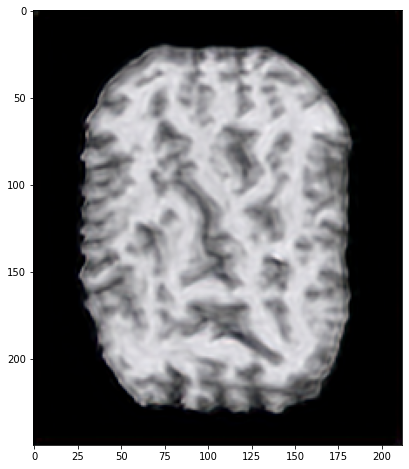

In [ ]:
if mode_of_generation=="random_sample":
    testing_image = Image.open(output_testing_path+"/"+mode_of_generation+"/"+mode_of_generation+"_"+str(scale)+".png", 'r')
elif mode_of_generation=="harmonization" or mode_of_generation=="editing" or mode_of_generation=="paint2image":
    testing_image = Image.open(output_testing_path+"/"+mode_of_generation+"/inject_at_"+str(scale)+".png")
else:
    testing_image = ""
    sys.exit("'mode_of_generation' is not correct and it is impossible to obtain the generated image. Try again.")

plt.figure(figsize=(8, 8))
plt.imshow(np.asarray(testing_image))
plt.show()